In [1]:
!nvidia-smi

Mon Jun 22 15:28:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!unzip '/content/269116_559533_compressed_AllProductReviews.csv.zip'

Archive:  /content/269116_559533_compressed_AllProductReviews.csv.zip
  inflating: AllProductReviews.csv   


## What is BERT?

BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers. If you don't know what most of that means - you've come to the right place! Let's unpack the main ideas:

- Bidirectional - to understand the text  you're looking you'll have to look back (at the previous words) and forward (at the next words)
- Transformers - The [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. `his` in a sentence refers to Jim).
- (Pre-trained) contextualized word embeddings - [The ELMO paper](https://arxiv.org/abs/1802.05365v2) introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. Let's look at examples of these tasks:

### Masked Language Modeling (Masked LM)

The objective of this task is to guess the masked tokens. Let's look at an example, and try to not make it harder than it has to be:

That's `[mask]` she `[mask]` -> That's what she said

### Next Sentence Prediction (NSP)

Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let's continue with the example:

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Hahaha, nice! [SEP]

*Label* = *IsNext*

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Dwight, you ignorant `[mask]`! [SEP]

*Label* = *NotNext*

The training corpus was comprised of two entries: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the decoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

### Is This Thing Useful in Practice?

The BERT paper was released along with [the source code](https://github.com/google-research/bert) and pre-trained models.

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance!

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [3]:
!pip install -q -U watermark

In [4]:
!pip install -qq transformers

     |████████████████████████████████| 675kB 4.7MB/s 
     |████████████████████████████████| 890kB 13.0MB/s 
     |████████████████████████████████| 3.8MB 23.6MB/s 
     |████████████████████████████████| 1.1MB 29.5MB/s 


In [5]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.0.4
torch 1.5.0+cu101
transformers 2.11.0


In [6]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda', index=0)

### Data Exploration

In [8]:
df = pd.read_csv("/content/AllProductReviews.csv")
df.head()

,ReviewTitle,ReviewBody,ReviewStar,Product
0,Honest review of an edm music lover\n,No doubt it has a great bass and to a great ex...,3,boAt Rockerz 255
1,Unreliable earphones with high cost\n,"This earphones are unreliable, i bought it be...",1,boAt Rockerz 255
2,Really good and durable.\n,"i bought itfor 999,I purchased it second time,...",4,boAt Rockerz 255
3,stopped working in just 14 days\n,Its sound quality is adorable. overall it was ...,1,boAt Rockerz 255
4,Just Awesome Wireless Headphone under 1000...😉\n,Its Awesome... Good sound quality & 8-9 hrs ba...,5,boAt Rockerz 255


In [9]:
df.shape

(14337, 4)

We have about 16k examples. Let's check for missing values:

In [10]:
df.ReviewBody[1]

'This  earphones are unreliable, i bought it before 15 days meanwhile right side ear buds got cracked automatically and it got divided in two parts, and sound quality is also not that much good but ok, one more thing bass is not good as it is a boat earphones.Guys,Also for the proof i have attached picsPlease see and think before buying\u200b this unreliable product.Thanks.\n'

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ReviewTitle  14337 non-null  object
 1   ReviewBody   14337 non-null  object
 2   ReviewStar   14337 non-null  int64 
 3   Product      14337 non-null  object
dtypes: int64(1), object(3)
memory usage: 448.2+ KB


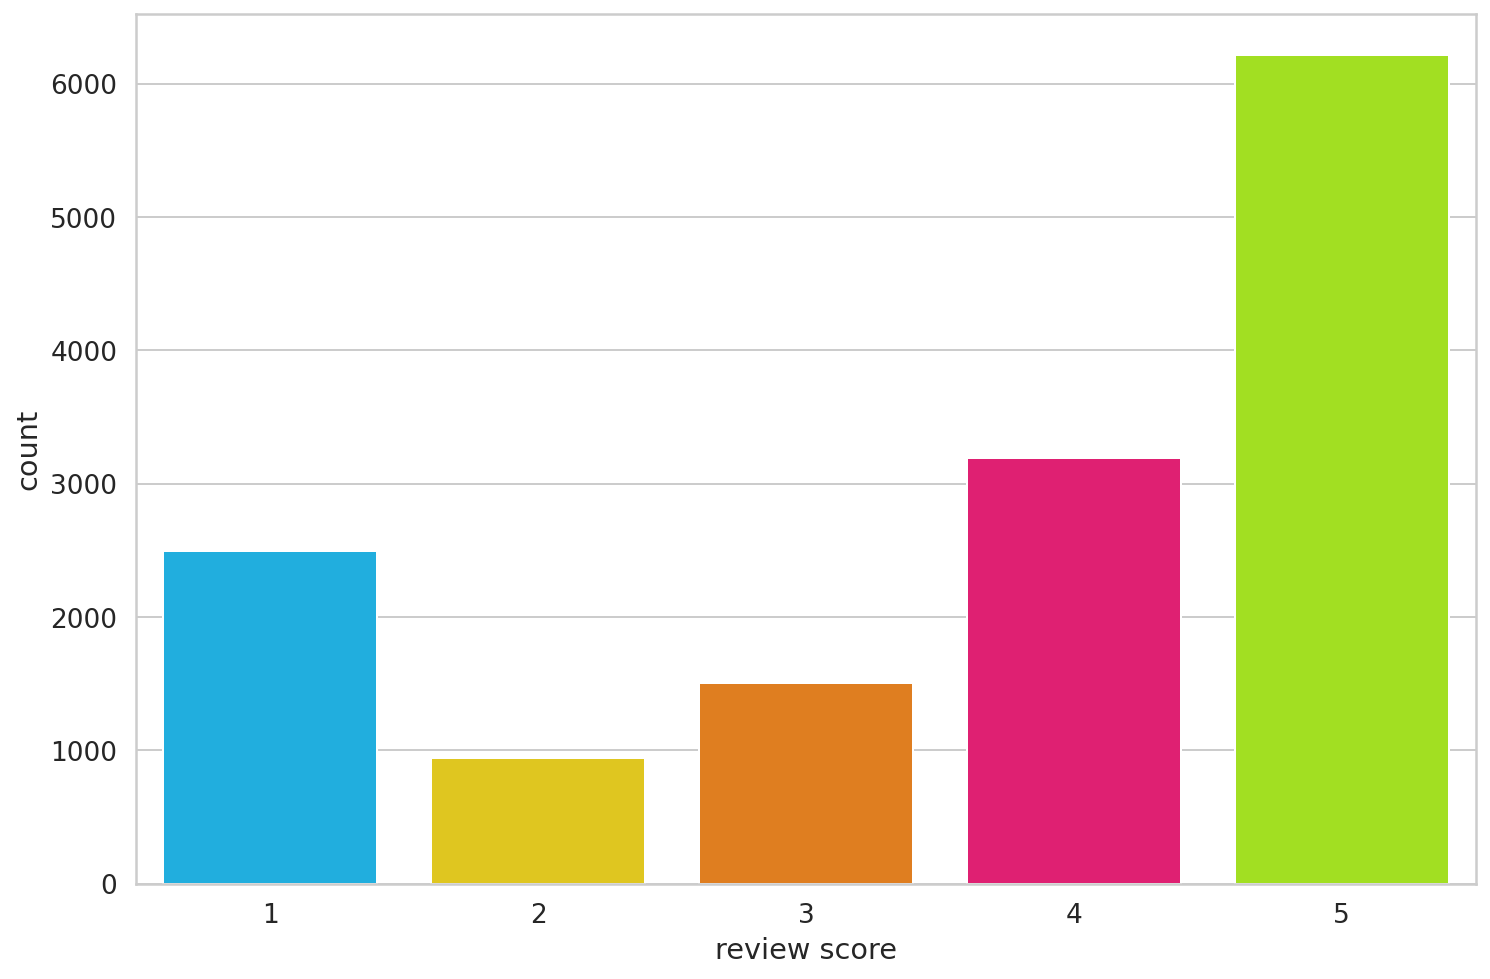

In [12]:
sns.countplot(df.ReviewStar)
plt.xlabel('review score');

In [13]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.ReviewStar.apply(to_sentiment)

In [14]:
class_names = ['negative', 'neutral', 'positive']

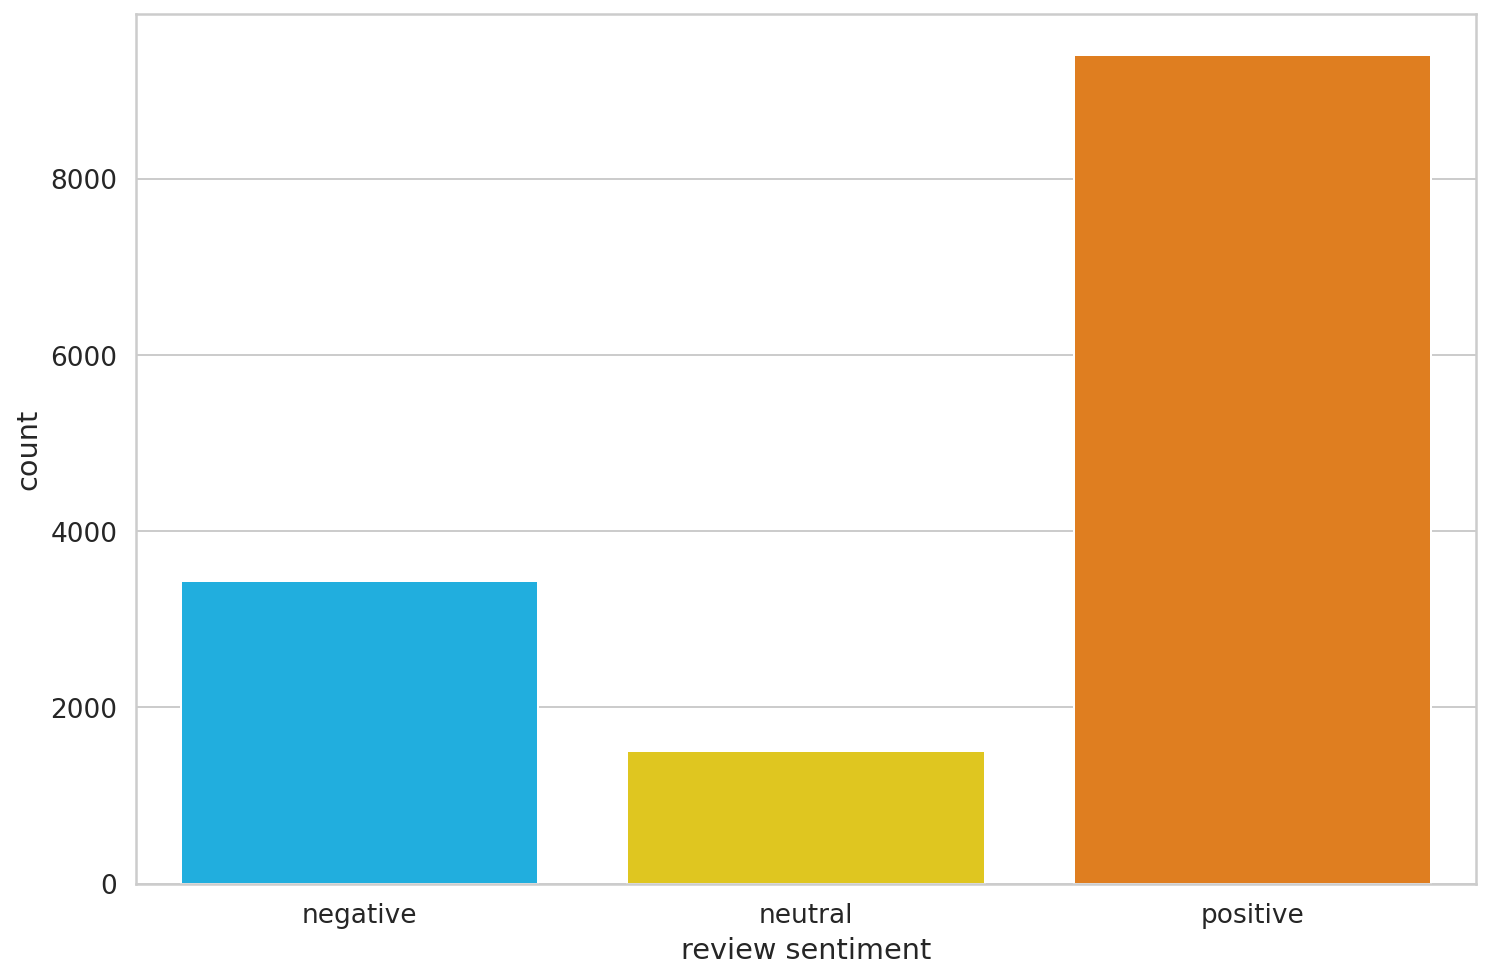

In [15]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [16]:
neg, neutral, pos = np.bincount(df.sentiment)

In [17]:
counts=[neg,neutral, pos]
counts

[3432, 1503, 9402]

In [18]:
n_classes=3
n_samples=sum(counts)
n_samples

14337

In [19]:
weights=[]
for count in counts:
    weights.append(n_samples / (n_classes * count))
    
weights=torch.tensor(weights)
weights

tensor([1.3925, 3.1796, 0.5083], dtype=torch.float64)

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [20]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [21]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We'll use this text to understand the tokenization process:

In [22]:
sample_txt = 'When was I last outside? \nI am stuck at home for 2 weeks.'

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [23]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? 
I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [24]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [25]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [26]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [27]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [28]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [29]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length:

In [30]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [31]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [32]:
token_lens = []

for txt in df.ReviewBody:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

and plot the distribution:

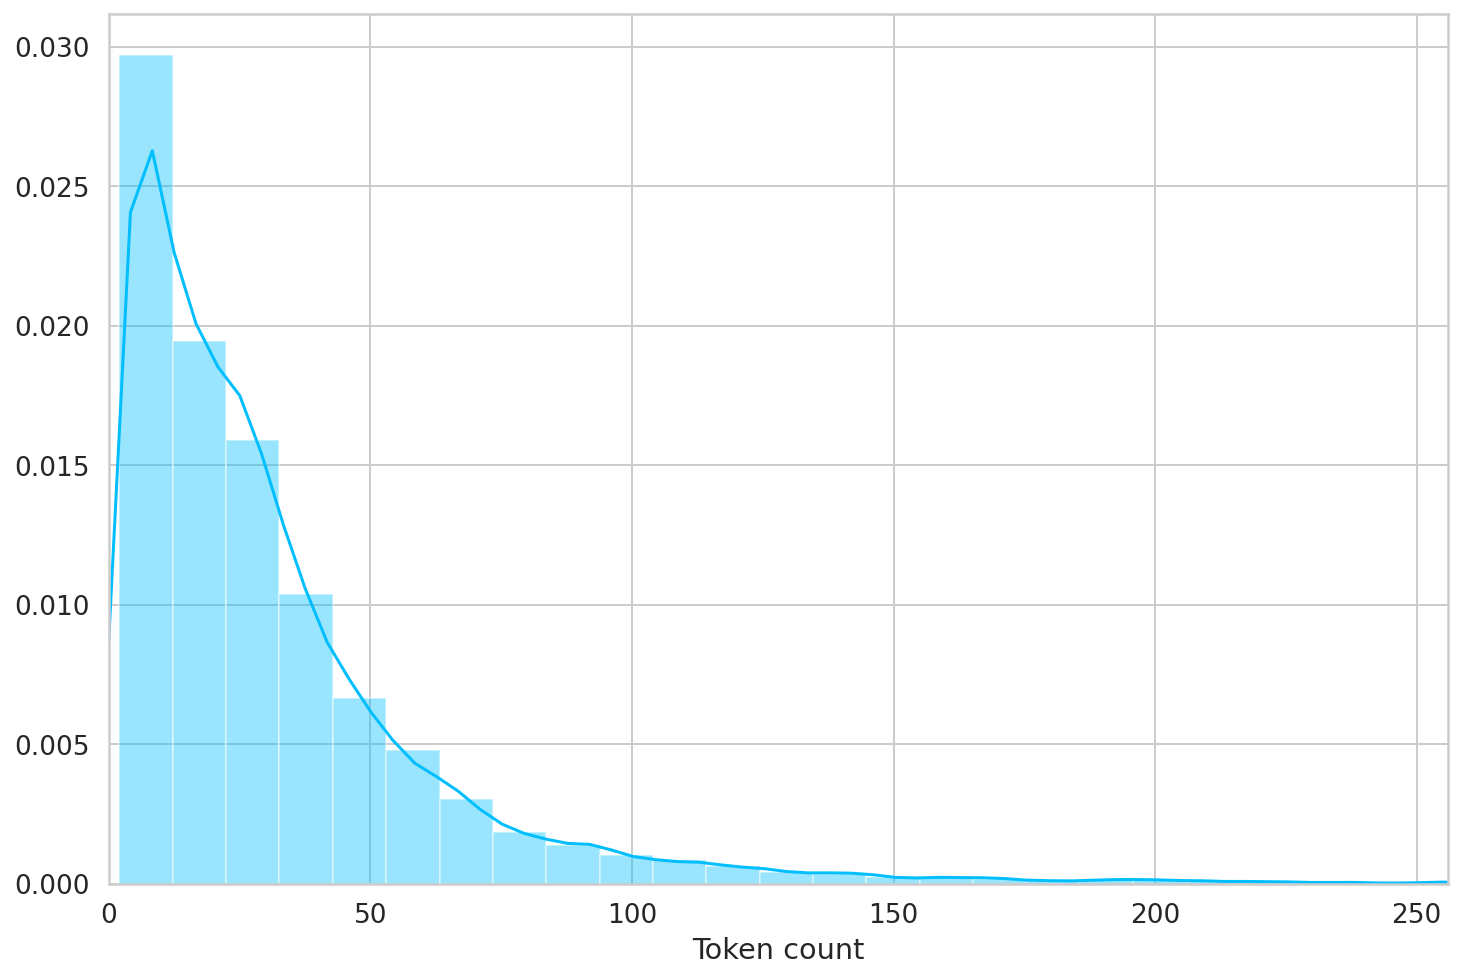

In [33]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [34]:
MAX_LEN = 150

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [35]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [36]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [37]:
df_train.shape, df_val.shape, df_test.shape

((12903, 5), (717, 5), (717, 5))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [38]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.ReviewBody.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [39]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [40]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [41]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [42]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And try to use it on the encoding of our sample text:

In [43]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [44]:
last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [45]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [46]:
pooled_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [47]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [48]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [49]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 150])
torch.Size([16, 150])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [50]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4186, 0.1725, 0.4088],
        [0.5265, 0.1442, 0.3293],
        [0.2867, 0.1925, 0.5208],
        [0.5164, 0.1286, 0.3550],
        [0.6016, 0.1623, 0.2361],
        [0.3043, 0.1720, 0.5237],
        [0.4239, 0.1353, 0.4407],
        [0.3147, 0.2535, 0.4318],
        [0.3214, 0.1467, 0.5319],
        [0.2685, 0.2363, 0.4952],
        [0.4077, 0.1860, 0.4063],
        [0.3707, 0.2242, 0.4051],
        [0.5429, 0.0844, 0.3727],
        [0.4866, 0.1555, 0.3579],
        [0.3742, 0.2358, 0.3900],
        [0.3471, 0.2099, 0.4431]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [51]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss(weight=weights.float()).to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [52]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [53]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [54]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7573614091862828 accuracy 0.7488956056730992
Val   loss 0.7222664899296231 accuracy 0.7447698744769874

Epoch 2/10
----------
Train loss 0.5702500596707122 accuracy 0.8321320623110904
Val   loss 0.7893716785642836 accuracy 0.796373779637378

Epoch 3/10
----------
Train loss 0.43111302649724625 accuracy 0.8897155700224754
Val   loss 1.1031437238057455 accuracy 0.7852161785216178

Epoch 4/10
----------
Train loss 0.32904270339279423 accuracy 0.9286987522281639
Val   loss 1.2877257585525512 accuracy 0.793584379358438

Epoch 5/10
----------
Train loss 0.2559414303092958 accuracy 0.9495466170657986
Val   loss 1.8302235556973352 accuracy 0.7894002789400278

Epoch 6/10
----------
Train loss 0.21080431468292027 accuracy 0.9613268232194063
Val   loss 1.8285463561614355 accuracy 0.8089260808926081

Epoch 7/10
----------
Train loss 0.16978887890801964 accuracy 0.9707044873285282
Val   loss 1.9568049300048087 accuracy 0.806136680613668

Epoch 8/10
----------
Trai

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

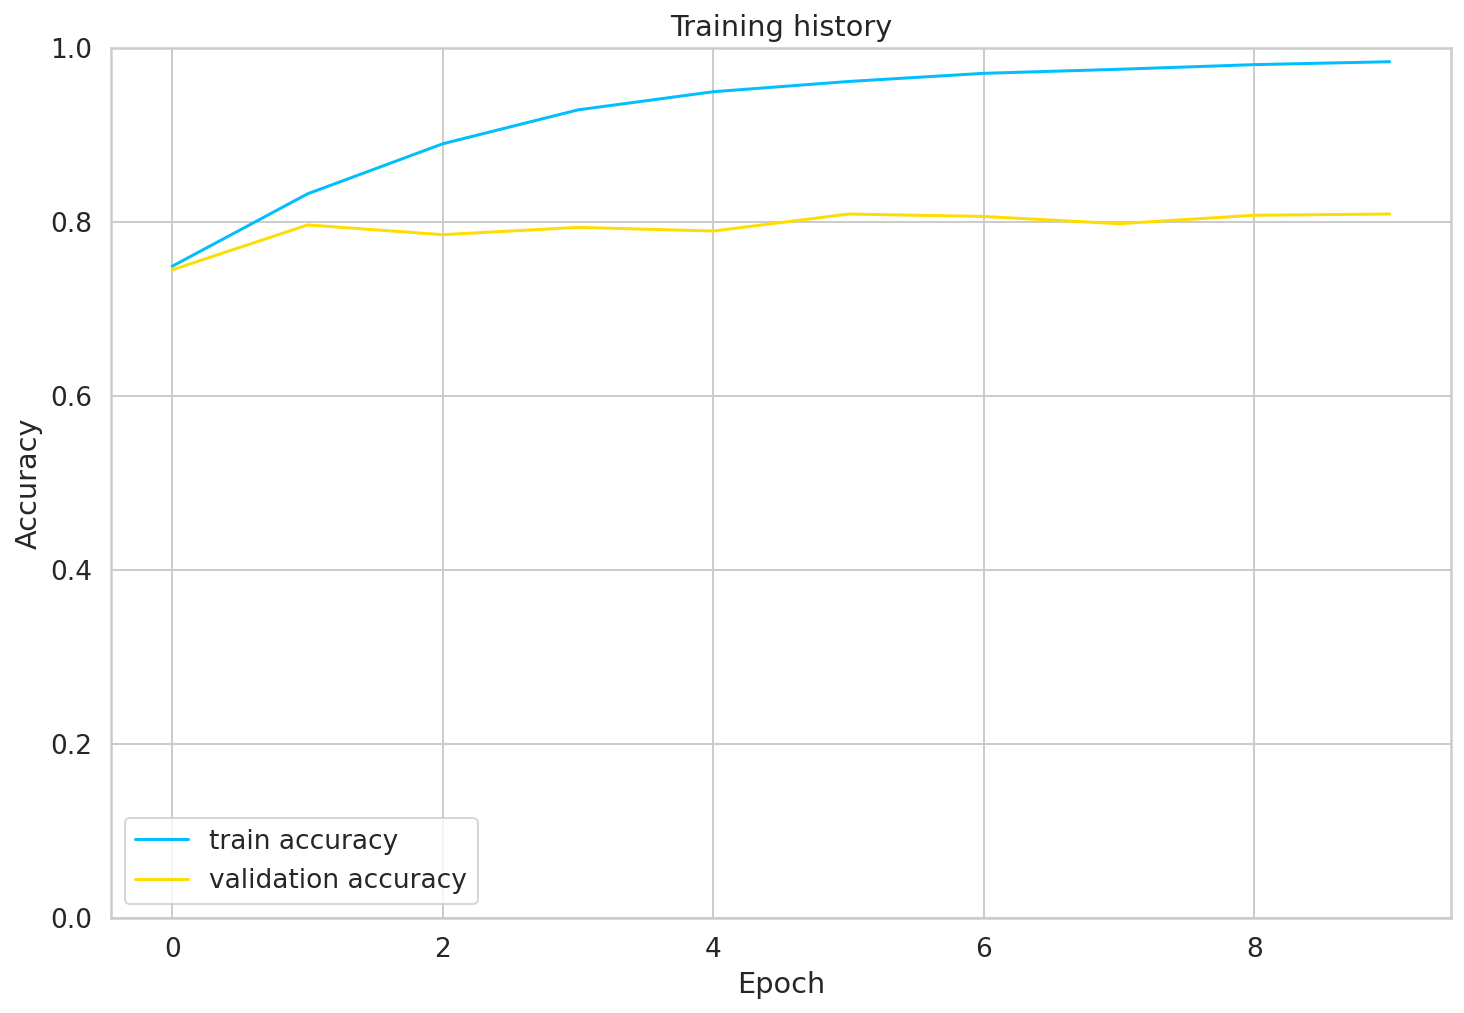

In [55]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [56]:


model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [57]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8145048814504882

In [58]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [59]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [60]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.79      0.75      0.77       165
     neutral       0.33      0.38      0.35        78
    positive       0.92      0.91      0.91       474

    accuracy                           0.81       717
   macro avg       0.68      0.68      0.68       717
weighted avg       0.82      0.81      0.82       717



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

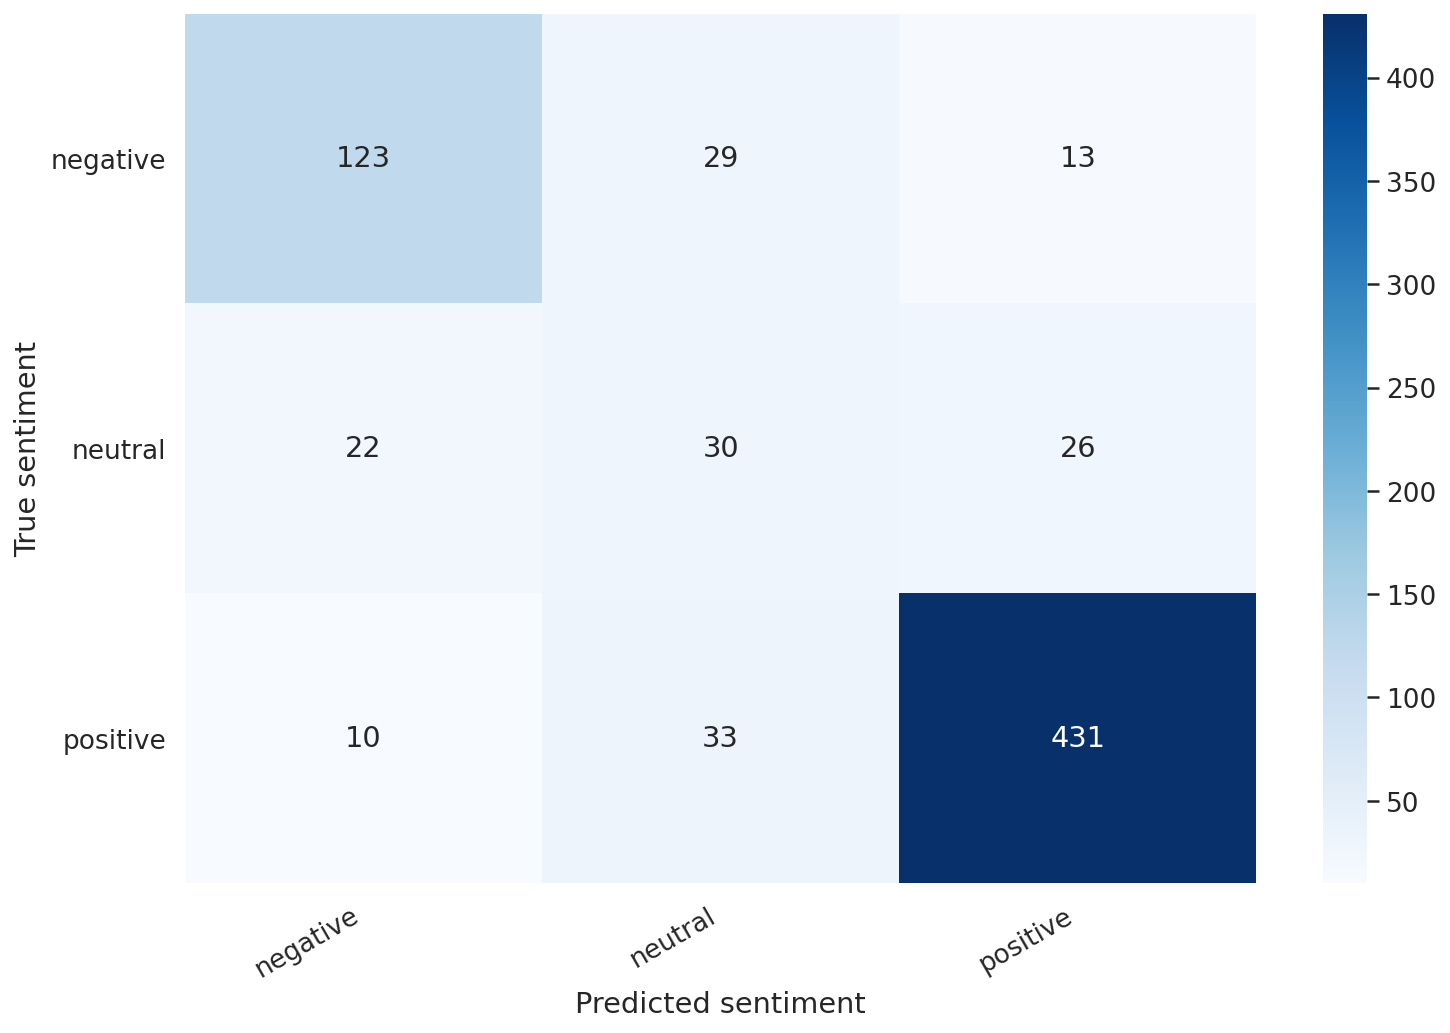

In [61]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [96]:
idx = np.random.randint(len(y_review_texts))

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')
pred_df

the output is average

True sentiment: neutral


,class_names,values
0,negative,0.001593
1,neutral,0.994602
2,positive,0.003805


Now we can look at the confidence of each sentiment of our model:

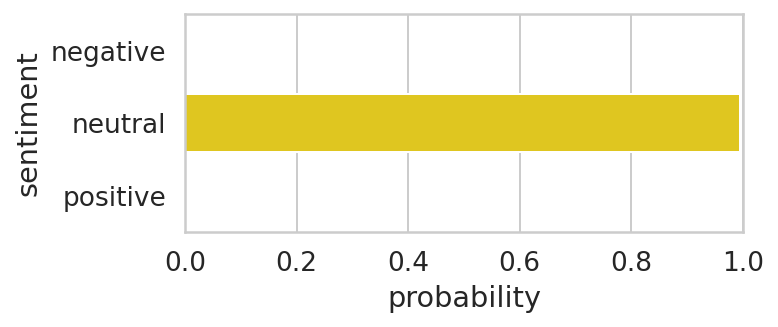

In [103]:
plt.figure(figsize=(5,2))
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [119]:
review_text = "its OK OK"

We have to use the tokenizer to encode the text:

In [120]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
probs = F.softmax(output, dim=1)
print(probs)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

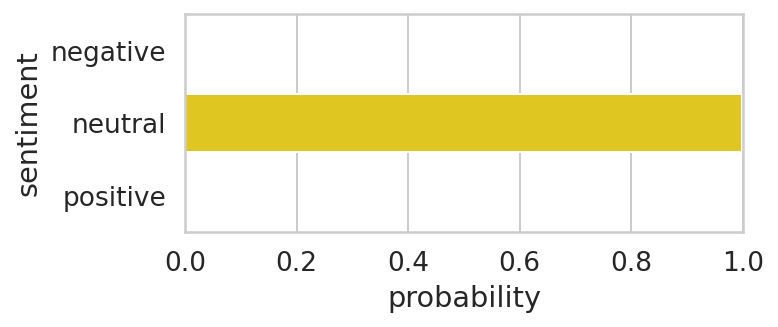

In [142]:
#@title Earphone Review Sentiment Predictor
review = "I bought this in sept and I'm NOT SATISFIED with the purchase... Don't get me wrong, the sound quality is amazing for a earphone this cheap, but its flat... The bass kicks in only when there's too much bass in the music, else the sound feels very flat... Also the audio via the microphone is bad, and the mic is located on the split end of the cable, which is very low... At times I've heard people complaining that they cannot hear my voice clearly... Only for those who are struck with the price tag of 300-400rs... In that range its good, but if you can spend a 100rs more, get the basshead 225.." #@param {type:"string"}
encoded_review = tokenizer.encode_plus(
  review,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
# print(attention_mask.shape)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
probs = F.softmax(output, dim=1)
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': probs.flatten().cpu().detach().numpy()
})

plt.figure(figsize=(5,2))
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

# print(f'Review text: {review_text}')
# print(f'Sentiment  : {class_names[prediction]}')